In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 1
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 1


### define tcobs, errorobs, p_init
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: good guesses for planets' mean periods

In [2]:
d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]

### define timestep dt, start/end times of integration

In [3]:
dt = 0.5 * 2
t_start, t_end = 155., 1495 + 1455
jttv = jaxttv(t_start, t_end, dt) # jaxttv class

# sympletic integrator is used.


### set observed transit times and errors (necessary to obtain model transit times)

In [4]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)


### least-squares fit for initializing HMC
- defaults to LM optimization with scipy.optimize.curve_fit
- if a good guess is not found, turning on amoeba may help

initial objective function: 5448.24 (53 data)

running LM optimization...
objective function: 49.90 (53 data)
# elapsed time (least square): 2.1 sec


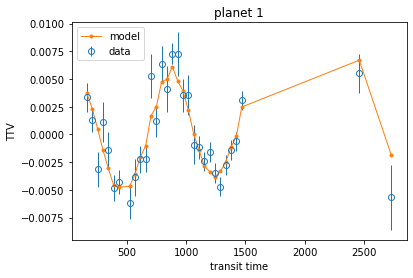

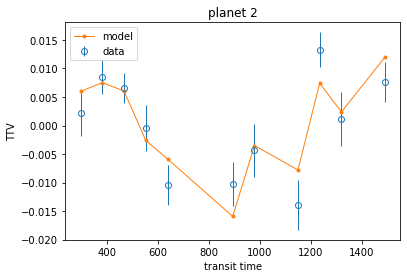

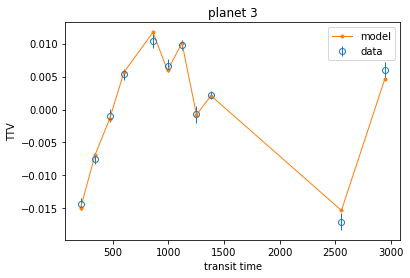

In [5]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.1)

In [6]:
tc = jttv.check_prec(params_best)

# fractional energy error (symplectic, dt=1.00e+00): 3.33e-09
# fractional energy error (Hermite, dt=4.52e-02): -5.62e-12
# max difference in tc: 6.17e-06 days (0.53 sec)


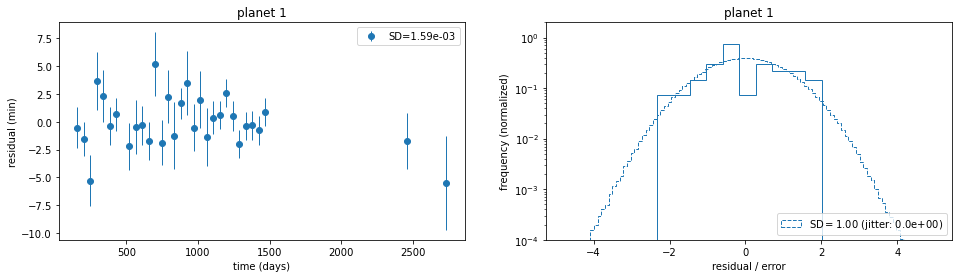

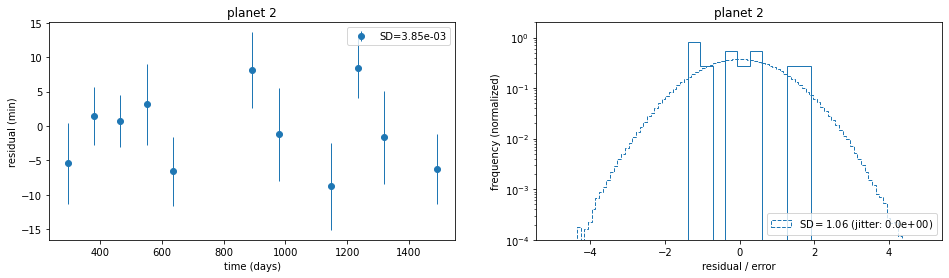

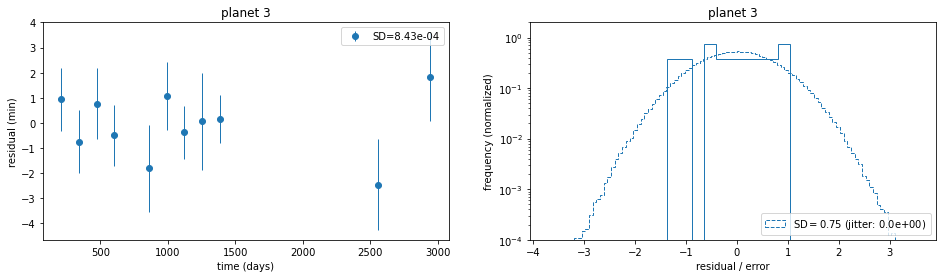

In [7]:
jttv.check_residuals(tc)

In [8]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

      pmass      period     ecosw     esinw  cosi  lnode         tic  \
0  2.976886   45.153999 -0.021525 -0.027961  -0.0   -0.0  159.110560   
1  4.136762   85.314202  0.014093 -0.004026  -0.0    0.0  295.320930   
2  5.461415  130.184130  0.007768 -0.003064   0.0    0.0  212.023457   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.035286 -2.226864 -11.624858  0.000009 -0.610006 -0.792397  
1  0.014656 -0.278290 -11.295823  0.000012  0.961527 -0.274712  
2  0.008350 -0.375708 -11.018028  0.000016  0.776750 -0.306385  


In [9]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

5.04 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### initialize HMC
- pdic_init: dict containing best-fit values
- tic_guess: used to set priors for times of inferior conjunction
- p_guess: used to set priors for osculating periods

In [10]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(jttv.p_init)
ones = jnp.ones_like(p_guess)

pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), 
                             outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
init_strategy = init_to_value(values=pdic_init)

def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=None):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    #elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    elements = jnp.array([period, ecc*jnp.cos(omega), ecc*jnp.sin(omega), cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    if tcjitter is not None:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-10, high=jnp.log(tcjitter)))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [11]:
pdic_init

{'period': DeviceArray([ 45.15399867,  85.31420164, 130.18413047], dtype=float64),
 'cosi': DeviceArray([-0., -0.,  0.], dtype=float64),
 'lnode': DeviceArray([-0.,  0.,  0.], dtype=float64),
 'tic': DeviceArray([159.11056011, 295.32093049, 212.02345656], dtype=float64),
 'ecc': DeviceArray([0.03528645, 0.01465644, 0.00834993], dtype=float64),
 'lnmass': DeviceArray([-11.62485799, -11.29582255, -11.01802794], dtype=float64),
 'mass': DeviceArray([8.94104583e-06, 1.24247196e-05, 1.64033014e-05], dtype=float64),
 'cosw': DeviceArray([-0.61000593,  0.96152651,  0.77675044], dtype=float64),
 'sinw': DeviceArray([-0.79239685, -0.27471215, -0.30638475], dtype=float64)}

In [12]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)

In [13]:
nw, ns, linm, tcjitter = 100, 100, True, None  # dt=1, all data, 1h50min

In [14]:
assert num_chains <= jax.local_device_count()
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=num_chains)

In [15]:
output = "kep51/dt%.1f_"%jttv.dt
if not linm:
    output += "logm"
if tcjitter is not None:
    output += "jit"
output += "nw%d_ns%d_"%(nw, ns)
if num_chains > 1:
    output += "c%d_"%num_chains

In [16]:
output

'kep51/dt1.0_nw100_ns100_'

In [18]:
import os, dill
posterior = output + "mcmc.pkl"
if os.path.exists(posterior):
    print (posterior + " loaded.")
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, mmin=0, mmax=5e-4, uniform_mass=linm, tcjitter=tcjitter)
    with open(base+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

kep51/dt1.0_nw100_ns100_mcmc.pkl loaded.


In [19]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]     -0.56      0.28     -0.54     -1.06     -0.20      7.82      1.12
   cosw[1]      1.44      0.29      1.42      1.04      1.90      3.98      2.04
   cosw[2]      0.57      0.43      0.45     -0.05      1.18      2.78      2.69
    ecc[0]      0.04      0.01      0.04      0.02      0.06      6.04      0.99
    ecc[1]      0.01      0.00      0.01      0.01      0.02      3.57      1.54
    ecc[2]      0.01      0.00      0.01      0.00      0.01      3.93      1.45
   mass[0]      0.00      0.00      0.00      0.00      0.00      4.65      1.32
   mass[1]      0.00      0.00      0.00      0.00      0.00      6.43      1.01
   mass[2]      0.00      0.00      0.00      0.00      0.00     11.67      1.17
 period[0]     45.15      0.00     45.15     45.15     45.15     13.67      1.00
 period[1]     85.31      0.00     85.31     85.31     85.32      6.48      1.38
 period[2]    130.18      0

In [20]:
samples = mcmc.get_samples()

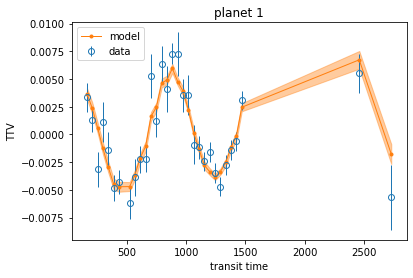

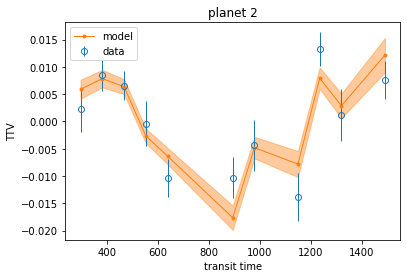

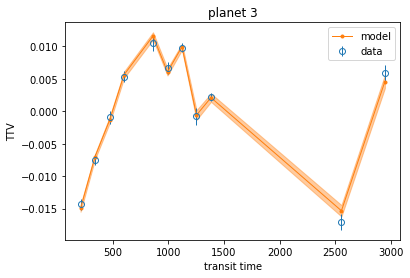

In [21]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel, save=output+"postm")

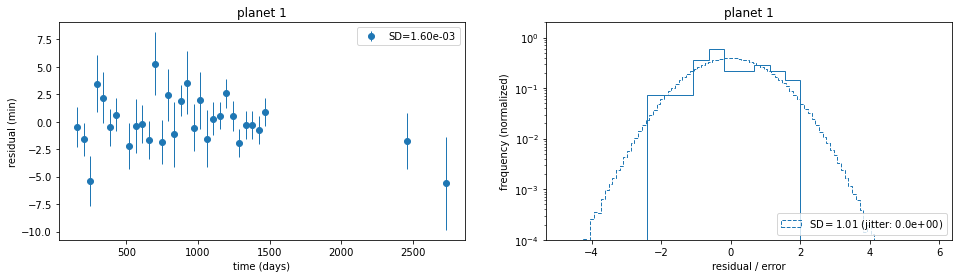

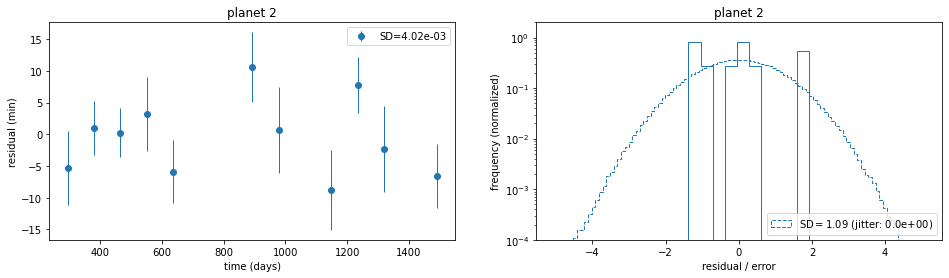

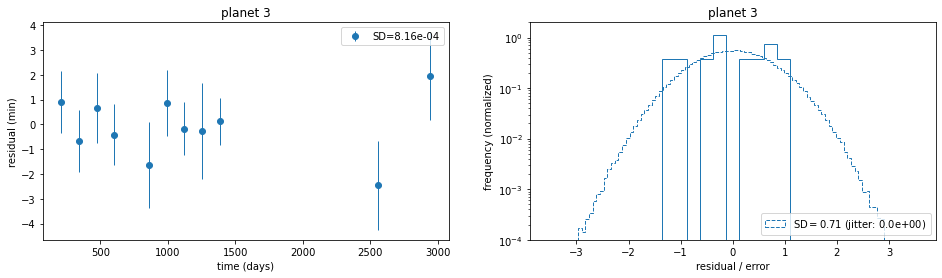

In [22]:
jttv.check_residuals(mmodel)

(array([ 5.,  6.,  6., 25., 11.,  9., 13., 10., 11.,  4.]),
 array([-8.56854674, -8.55051651, -8.53248629, -8.51445606, -8.49642583,
        -8.47839561, -8.46036538, -8.44233515, -8.42430493, -8.4062747 ,
        -8.38824447]),
 <BarContainer object of 10 artists>)

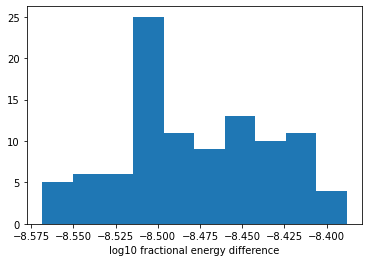

In [23]:
plt.xlabel("log10 fractional energy difference")
plt.hist(np.log10(np.abs(samples['ediff'])))

In [24]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

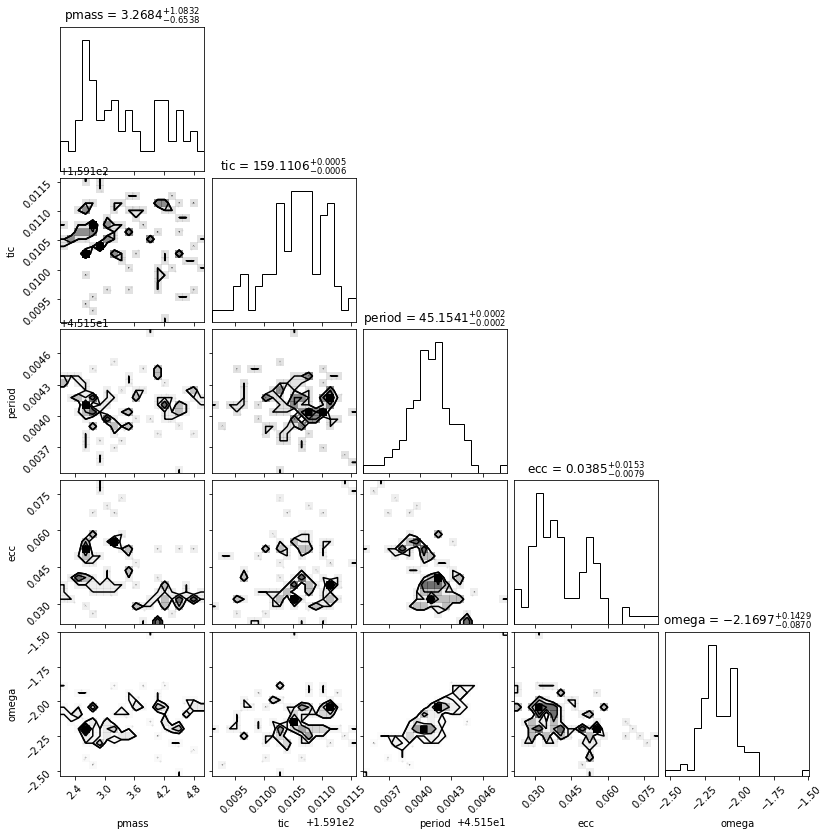

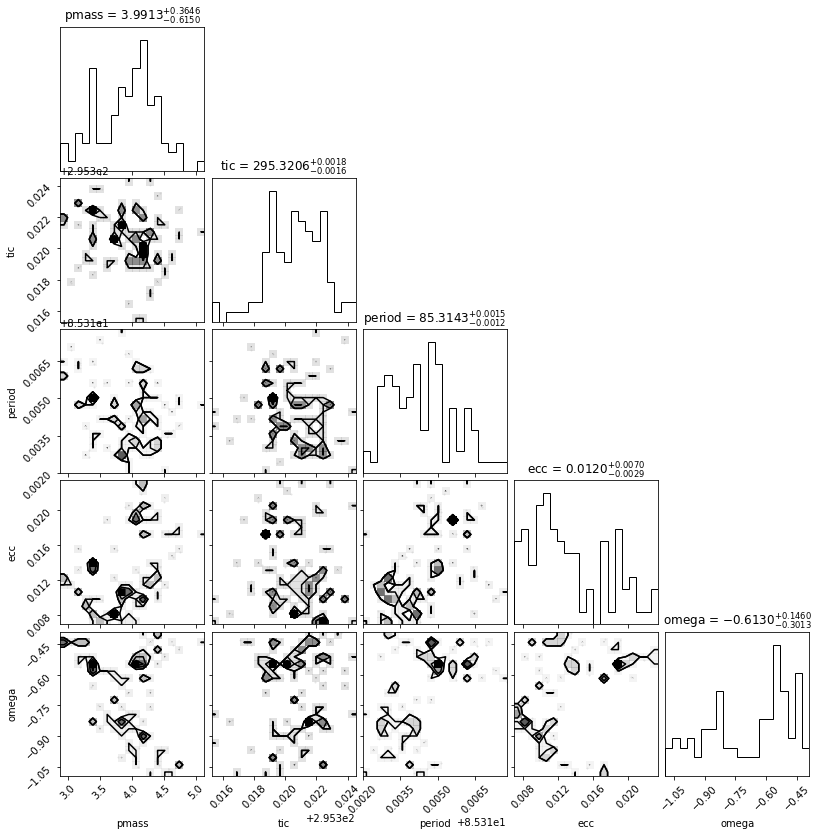

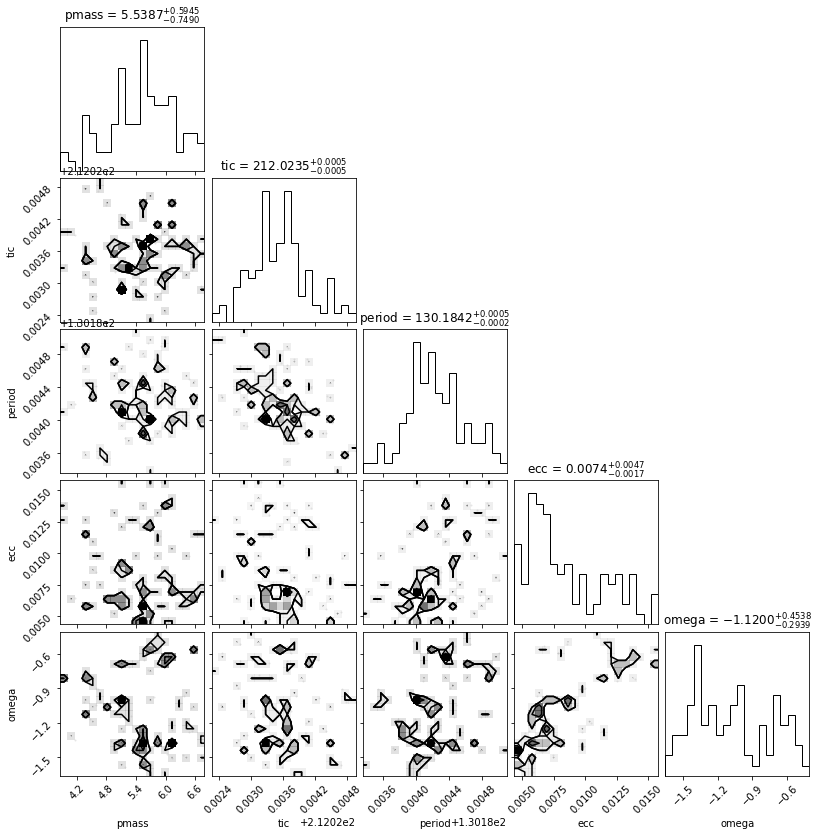

In [25]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    if tcjitter is not None:
        hyper['lntcjitter'] = samples['lntcjitter']
        labels = keys + ['lntcjitter']
    else:
        labels = keys
    fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt=".4f")
    plt.savefig(output+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");

### check convergence of transit times

In [26]:
jttv2 = jaxttv(t_start, t_end, dt / 10.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# sympletic integrator is used.
# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           0.1000 (1/451 of innermost period)


(array([ 2.,  0.,  2.,  8., 14., 16.,  4.,  1.,  2.,  4.]),
 array([-0.43414016, -0.35829073, -0.2824413 , -0.20659187, -0.13074244,
        -0.05489301,  0.02095643,  0.09680586,  0.17265529,  0.24850472,
         0.32435415]),
 <BarContainer object of 10 artists>)

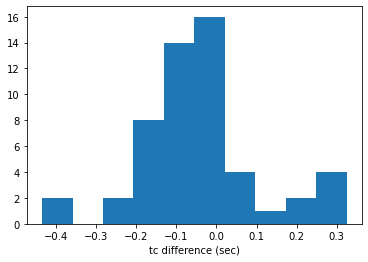

In [27]:
k = 50
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))
plt.xlabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400.)